In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
CUTOFF  = 8
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


coords, deflection, boundary = read_data('../../../tractionforce/data/t2.txt')
x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=CUTOFF)

del distances2d, mask, boundary2d
gc.collect()

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

u_x_in = deflection[condition_inside]
u_x_out = deflection[condition_outside]

n_in = len(x_in)
n_out = len(x_out)

print("Size of the problem is " + str( n_in + n_out))

deltax_in_in = x_in[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltax_out_in = x_out[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltay_in_in = y_in[...,np.newaxis] - y_in[np.newaxis, ...]  # y - y'
deltay_out_in = y_out[...,np.newaxis] - y_in[np.newaxis,...] # y - y'

l2_in_plus_in_plus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_plus_in_minus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_plus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_minus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy+ dy/2.0]) ** 2).sum(axis=0) ** 0.5

l2_out_plus_in_plus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_plus_in_minus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_plus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_minus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy + dy/2.0]) ** 2).sum(axis=0) ** 0.5

x_adjacency = sparse.csr_matrix((deltax_in_in == -1)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
y_adjacency = sparse.csr_matrix((deltay_in_in == -1)*(deltax_in_in == 0)*-1 + (deltay_in_in == 1)*(deltax_in_in == 0)*1)

A_in_in = fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) -\
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

A_out_in = fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
          fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) -\
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

D_in_in = fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) - \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

D_out_in = fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
           fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) - \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

B_in_in = x_in[..., np.newaxis]*A_in_in - fxxx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
              fxxx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) +\
              fxxx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
              fxxx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

B_out_in = x_out[..., np.newaxis]*A_out_in - fxxx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
          fxxx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) +\
          fxxx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
          fxxx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

C_in_in = y_in[..., np.newaxis]*A_in_in - fxxy(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
          fxxy(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
          fxxy(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
          fxxy(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

C_out_in = y_out[..., np.newaxis]*A_out_in - fxxy(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
           fxxy(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
           fxxy(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
           fxxy(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

E_in_in = x_in[..., np.newaxis] * D_in_in - fxyx(deltax_in_in - dx / 2., deltay_in_in - dy / 2.0,
                                                 l2_in_plus_in_plus) + \
          fxyx(deltax_in_in - dx / 2., deltay_in_in + dy / 2.0, l2_in_plus_in_minus) + \
          fxyx(deltax_in_in + dx / 2., deltay_in_in - dy / 2.0, l2_in_minus_in_plus) - \
          fxyx(deltax_in_in + dx / 2., deltay_in_in + dy / 2.0, l2_in_minus_in_minus)

E_out_in = x_out[..., np.newaxis] * D_out_in - fxyx(deltax_out_in - dx / 2., deltay_out_in - dy / 2.0,
                                                   l2_out_plus_in_plus) + \
           fxyx(deltax_out_in - dx / 2., deltay_out_in + dy / 2.0, l2_out_plus_in_minus) + \
           fxyx(deltax_out_in + dx / 2., deltay_out_in - dy / 2.0, l2_out_minus_in_plus) - \
           fxyx(deltax_out_in + dx / 2., deltay_out_in + dy / 2.0, l2_out_minus_in_minus)

F_in_in = y_in[..., np.newaxis]*D_in_in - fxyx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
          fxyx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
          fxyx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
          fxyx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

F_out_in = y_out[..., np.newaxis]* D_out_in - fxyx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
           fxyx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
           fxyx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
           fxyx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

# make derivative matrices Lx Ly

Dx = sparse.csr_matrix((deltax_in_in == 0)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
rowsums = np.squeeze(np.asarray((Dx.sum(axis=1) != 0)))
Dx[rowsums,:] = 0
Dx.eliminate_zeros()
Dx = Constant(Dx)

Dy = sparse.csr_matrix(
    (deltay_in_in == 0) * (deltax_in_in == 0) * -1 + (deltay_in_in == 1) * (deltax_in_in == 0) * 1)
rowsums = np.squeeze(np.asarray((Dy.sum(axis=1) != 0)))
Dy[rowsums,:] = 0
Dy.eliminate_zeros()
Dy = Constant(Dy)

del deltax_in_in, deltay_in_in, deltax_out_in, deltay_out_in
del l2_in_plus_in_plus, l2_in_plus_in_minus, l2_in_minus_in_plus, l2_in_minus_in_minus
del l2_out_plus_in_plus, l2_out_plus_in_minus, l2_out_minus_in_plus, l2_out_minus_in_minus
gc.collect()

gamma = Parameter(sign="positive",value=1)

sigma = Variable(n_in,2)

# predicted_in = A_in_in*sigma_xz + D_in_in*sigma_yz # add higher order terms
predicted_in = (A_in_in + B_in_in + C_in_in )*1e-3* sigma[:,0] + (D_in_in + E_in_in + F_in_in )*1e-3* sigma[:,1]
# predicted_out =  A_out_in*sigma_xz + D_out_in*sigma_yz
predicted_out = (A_out_in + B_out_in + C_out_in)*1e-3* sigma[:,0] + (D_out_in + E_out_in + F_out_in)*1e-3* sigma[:,1]


error = sum_squares(u_x_in - predicted_in) + sum_squares(u_x_out - predicted_out)

forceconstraints = [sum_entries(sigma[:,0])==0, sum_entries(sigma[:,1])==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma[:,1]) - mul_elemwise(y_in-y_center,sigma[:,0]))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints

Size of the problem is 2196


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [3]:
regularity_penalty = sum_squares(pnorm(sigma,2, axis=1))
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_values = []

u_x_values = []


In [4]:
num_cores = multiprocessing.cpu_count()

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= False, max_iters = 50,
                   warm_start=True, solver = cvxpy.ECOS,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_values.append(sigma.value)

    force = np.zeros_like(coords)
    force[condition_inside,0] = sigma[:,0].value.reshape((n_in,))
    force[condition_inside,1] = sigma[:,1].value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in.value
    u_x[condition_outside] = predicted_out.value
    #u_x_values.append(u_x)

    return force, u_x, error.value, regularity_penalty.value, val


results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: assignment will raise an error in the future, most likely because your index r

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: assignment will raise an error in the future, most likely because your index r

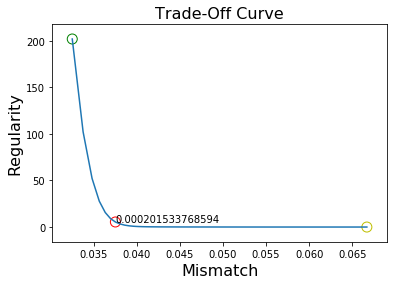

In [5]:
data_error = [res[2] for res in results]
reg_error = [res[3] for res in results]
lvals = [res[4] for res in results]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.plot( data_error, reg_error)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

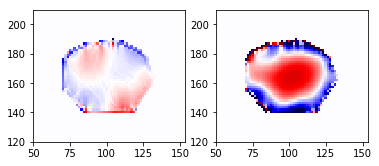

In [6]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[best][0][:,0]
Fy = results[best][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')


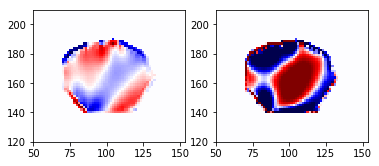

In [7]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[0][0][:,0]
Fy = results[0][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')


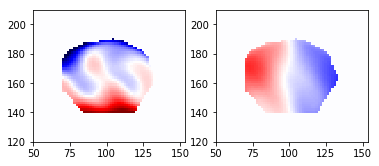

In [8]:
x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])
plt.subplot(121)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
Fx = results[-1][0][:,0]
Fy = results[-1][0][:,1]
maxmagnitude = np.max(np.abs(Fx))

plt.pcolormesh(x_obs_positions,y_obs_positions,Fx.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
plt.subplot(122)
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.pcolormesh(x_obs_positions,y_obs_positions,Fy.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                           cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')


In [9]:
import pickle
import gzip

with gzip.open('../results/anisotropic_L2_results.gz','wb') as f:
    pickle.dump(results + [ [x_obs_positions,y_obs_positions]],f)

In [10]:
#import pickle
#import gzip

#results = pickle.load(gzip.open('results/trace_L1_results.gz','rb'))